<a href="https://colab.research.google.com/github/Talisra/MonkeyClassifier/blob/master/MonkeyClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from pathlib import Path
import pandas as pd
import json,codecs

import scipy.signal
import random
import itertools
import numpy as np
from collections import Counter

import cv2
import imgaug as aug
import imgaug.augmenters as iaa

from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model
from keras.layers import Conv2D,Input,MaxPooling2D, Dense, Dropout, Flatten, Activation,ZeroPadding2D, Average
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, Callback

from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50


%matplotlib inline

Using TensorFlow backend.


Finals for the project

---



In [0]:
target_height = 112
target_width = 112
test_split = 0.2
start_seed = 100
epochs_to_run = 20 #Each time I ran a different epochs because the GPU of google is limited. When I was satisfied with the results there is no need to run more epochs.
epoch_size = 100

Rearrange paths + drive mount. I uploaded the data to my google drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
main_path = r'/content/drive/My Drive/Image Database/Monkeys'
train_path = main_path + r'/training'
test_path = main_path + r'/validation'

weight_path_inc = r'/content/drive/My Drive/Image Database/Monkeys/inc_weights.hdf5'
hist_path_inc = r'/content/drive/My Drive/Image Database/Monkeys/inc_history.json'

weight_path_x = r'/content/drive/My Drive/Image Database/Monkeys/x_weights.hdf5'
hist_path_x = r'/content/drive/My Drive/Image Database/Monkeys/x_history.json'

weight_path_res = r'/content/drive/My Drive/Image Database/Monkeys/res_weights.hdf5'
hist_path_res = r'/content/drive/My Drive/Image Database/Monkeys/res_history.json'

# Image preprocess

---

The data comes at two folders of validation and test, already splitted up. I load them and then decide if I want to split it as a new test-train (for better results), or leave it like that.
the data is in the format of the path and its label, instead of the image and its label, because it is more efficient to work with paths than images.

In [0]:
x_train = []
y_train = []

for inx,row in enumerate(os.walk(train_path)):
    if inx ==0:
        label = row[1]
    else:
        label,dic,data = row
        for img in data:
            x_train.append(os.path.join(label,img))
            y_train.append(label.split('/')[-1])
            
x_test = []
y_test = []

for inx,row in enumerate(os.walk(test_path)):
    if inx ==0:
        label = row[1]
    else:
        label,dic,data = row
        for img in data:
            x_test.append(os.path.join(label,img))
            y_test.append(label.split('/')[-1])    

One hot transformation


In [0]:
#One-hot transformations

#Transfers a label to an array with n-zeros, and the right class is '1'.
def one_hot(y,n):
    array = np.zeros([n])
    array[y] = 1
    return array

#Transfers all labels in the y array to one-hot.
def to_one_hot_array(y_label):
    #creates a dictionary for classifying the names as numbers
    n_counter = 0
    n_dict = {}
    for name in sorted(Counter(y_train)):
        n_dict[name] = n_counter
        n_counter+=1
    #each label gets his one_hot array
    n_classes = len(Counter(y_train))
    y = []
    for row in y_label:
        label = n_dict[row]
        y.append(one_hot(label,n_classes))
    y = np.array(y)
    return y

#Functions to convert the data so it would be easier to analyze
def one_hot_to_class(onehot_array):
    newlist = [np.where(r==1)[0][0] for r in onehot_array]
    return [number for number in newlist]


#makes one-hot arrays with the above funcs
y_train_one_hot = to_one_hot_array(y_train)
y_test_one_hot = to_one_hot_array(y_test)




Kaggle's data is already splitted to a test/train sets, so I added an option to resplit it randomly. To do just change resplit_data = True


In [0]:
resplit_data = False #True = resplit test/train, False = keep it like the split from Kaggle

def load_data(image_list,labels):
    X_train, X_test, Y_train, Y_test = train_test_split(image_list,labels, test_size= test_split, shuffle=True) #Kaggle's sets are at 0.2 test, 0.8 train, so I keep it like that.
    (x_train,y_train) = (X_train,Y_train)
    (x_test,y_test) = (X_test,Y_test)
    return (x_train,y_train),(x_test,y_test)

if resplit_data:
    x_train.append(x_test)
    y_train.append(y_test)
    (x_train,y_train),(x_test,y_test) = load_data(x_train,y_train)

# Data Presentation

---

Presents the number of images, test and train for each label. Also provides the label name and latin/common name of the label. I will use the common name instead of the latin name.

In [8]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
label_data = pd.read_csv(main_path + f"/monkey_labels.txt", names=cols, skiprows=1)
label_data

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [0]:
#Creating a python dic, easier to convert between the common names and labels. Also set the monk_classes variable by the number of entries in the dict.
m_dict = {}
labels = label_data['Common Name']
counter = 0
for n_class in sorted(Counter(y_train)):
    m_dict[int(n_class[-1])] = labels[counter].strip()
    counter+=1
    
monk_classes = counter

In [10]:
m_dict

{0: 'mantled_howler',
 1: 'patas_monkey',
 2: 'bald_uakari',
 3: 'japanese_macaque',
 4: 'pygmy_marmoset',
 5: 'white_headed_capuchin',
 6: 'silvery_marmoset',
 7: 'common_squirrel_monkey',
 8: 'black_headed_night_monkey',
 9: 'nilgiri_langur'}

**Examples**

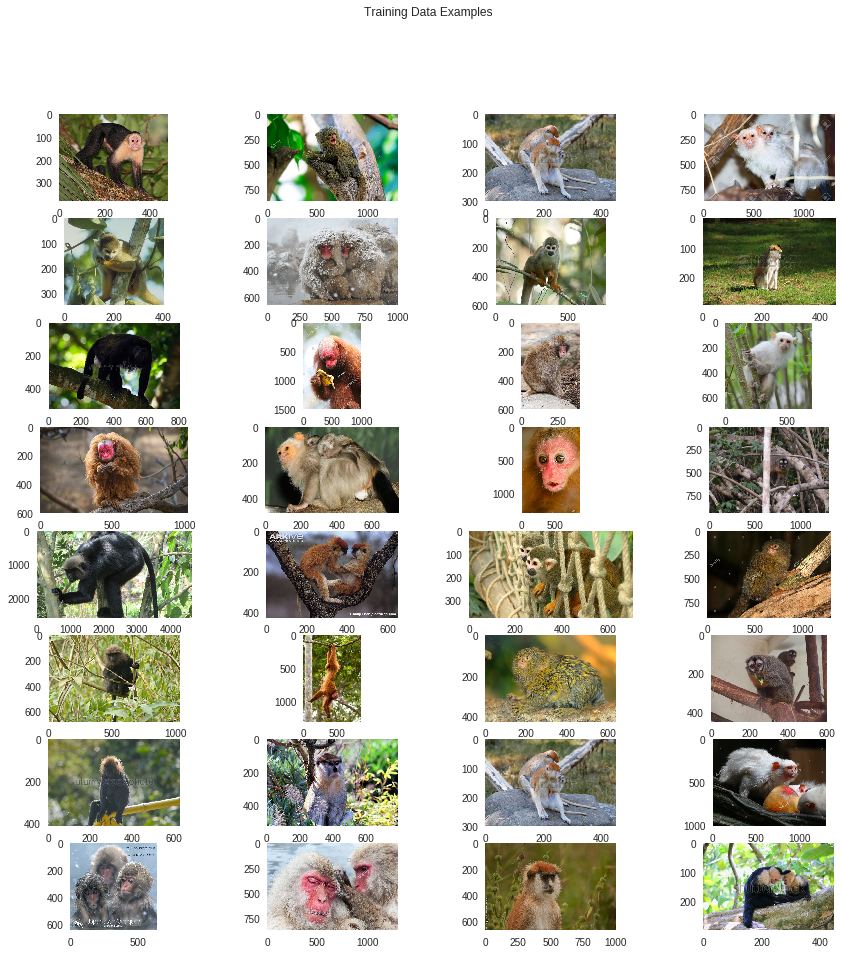

In [11]:
num_of_ex = 5


rows = 8
cols = 4
pic_idx = 0
f, axarr = plt.subplots(rows, cols, figsize=(15, 15))
for row in range(rows):
    for col in range(cols):
        pic_idx = np.random.randint(0,len(x_train)-1)
        axarr[row][col].imshow(plt.imread(x_train[pic_idx]))
        #axarr[row][col].title(m_dict[int((y_train[pic_idx][-1]))])
        axarr[row][col].grid(None)
        pic_idx+=1
plt.suptitle('Training Data Examples')
plt.show()

# plt.figure(figsize = (15,5))
# for img in range(num_of_ex):
#     pic = np.random.randint(0,len(x_train)-1)
#     plt.subplot(1,num_of_ex,img+1)
#     image = plt.imread(x_train[pic])
#     plt.imshow(image)
#     plt.title(m_dict[int((y_train[pic][-1]))])
#     plt.grid(None)
# plt.suptitle('Training images examples')
# plt.show()


# Augmentations

---

I used keras' ImageDataGenerator to perform image augmentations. It helps me with the augmentations implementation, the one-hot convert, the random seed, and the generator itself.

Augmentation class I created, performing various augmentations that are not implemented in keras' generator.

In [0]:
# #old generators I used before and decided not to delete

# aug_gen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=45, width_shift_range=0.15, height_shift_range=0.15, shear_range=0.15, zoom_range=0.15, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=True, vertical_flip=False, rescale=1. / 255, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)

# aug_train = aug_gen.flow_from_directory(Path(train_path) , target_size=(target_height, target_width) , color_mode='rgb', batch_size=32, class_mode='categorical', shuffle=True, seed=start_seed)
# aug_test = aug_gen.flow_from_directory(Path(test_path) , target_size=(target_height, target_width) , color_mode='rgb', batch_size=32, class_mode='categorical', shuffle=True, seed=start_seed)

# #generator to load an image from path + performing extra augs
# def extra_aug_generator(generator):
#     while True:
#         tmp = next(generator)
#         x = []
#         for img in tmp[0]:
#             x.append(my_aug.get_aug(img))
#         yield np.asarray(x), tmp[1]

# #train generator will perform more augmentations than the test generator, hopefully to reduce overfitting.
# my_gen_train = extra_aug_generator(aug_train)
# my_gen_test = extra_aug_generator(aug_test)

I used imgaug augmentations to expand my data

In [0]:
seq = iaa.SomeOf((0, 3),([
     iaa.Fliplr(0.85), # horizontal flips
     iaa.Affine(rotate=(-30, 30)), # roatation
     iaa.Multiply((1.2, 1.5)), #random brightness
     iaa.AdditiveGaussianNoise(25), #noise
     iaa.GaussianBlur(sigma=(0, 2.0))])) # blur images with a sigma of 0 to 3.0
     #iaa.SaltAndPepper(6, False), #salt and pepper
     #iaa.Grayscale(alpha=(0.8, 1.0)) #grayscale
     #iaa.Sharpen(0.5, 1) #sharpen


Generator I created that load a path and label, loads the image, resizes it, and then performs augmentations.

In [0]:
def data_generator(path,label, batch_size = 32, shuffle=True):
    start = 0
    if shuffle:
        data = list(zip(path,label))
        np.random.shuffle(data) #shuffles the tuples of path and label
        path, label = zip(*data)
    while True:
        images = []
        labels = []
        idx=0
        for img in range(batch_size):
            if start+idx >= len(path):
                start = 0
                idx = 0
            picture = load_image(path, start+idx) #loading a resized, augmented picture.
            images.append(picture)
            labels.append(one_hot(int(label[start+idx][-1]),monk_classes))
            idx+=1
        start+=batch_size
        yield np.asarray(images),np.asarray(labels)

def load_image(train, index): #index must be a number between 0 to the same len(train)
    #this function reads an image with the given path, resizes it to a fixed size, and then performs augmentations.
    image = plt.imread(train[index])
    img = cv2.resize(image, (target_height, target_width))
    image = seq.augment_image(img)
    return image
    

In [0]:
train_gen = data_generator(x_train,y_train, batch_size = 32, shuffle=True)
test_gen = data_generator(x_test,y_test, batch_size = 32, shuffle=False)


<Figure size 2160x2160 with 0 Axes>

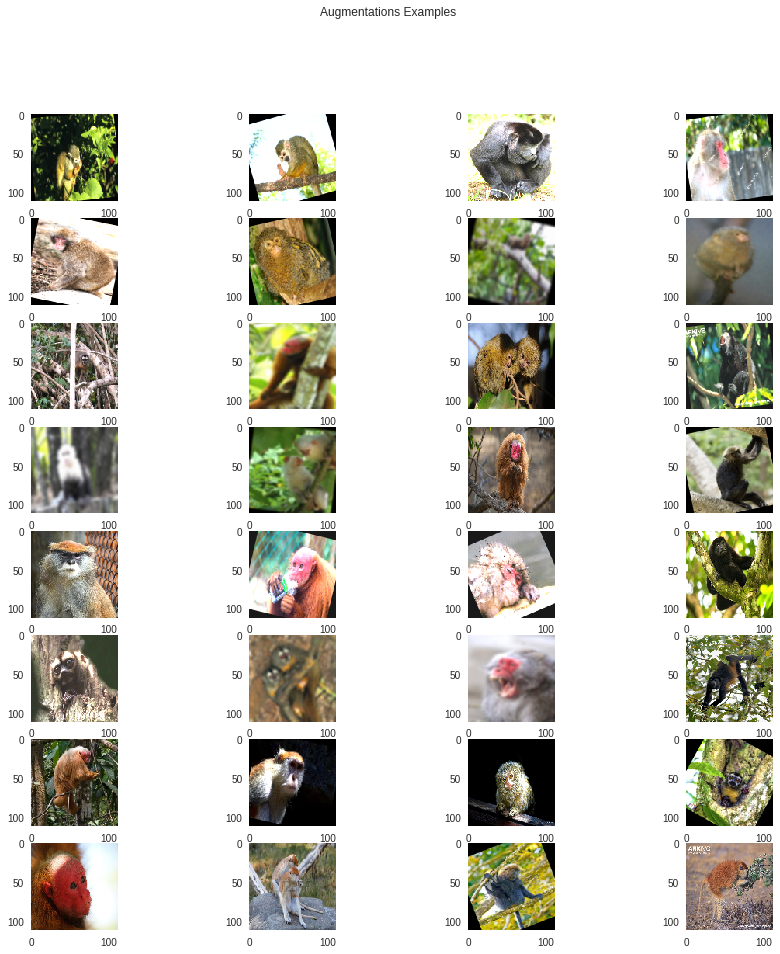

In [16]:
plt.figure(figsize = (30,30))
batch = next(train_gen)
batch_class = one_hot_to_class(batch[1])

rows = 8
cols = 4
pic_idx = 0
f, axarr = plt.subplots(rows, cols, figsize=(15, 15))
for row in range(rows):
    for col in range(cols):
        axarr[row][col].imshow(batch[0][pic_idx])
        axarr[row][col].grid(None)
        pic_idx+=1
plt.suptitle('Augmentations Examples')
plt.show()

# Building CNNs

---
I built 2 cnns from keras application: Inception V3 and Xception.
I trained the database on the nets and then ensembled for a better result.


Callbacks

---

These are callbacks I used, so it will be easier to work from colab

In [0]:
#List of callbacks to send

#callback to save the best weights of the model.
callback_i = ModelCheckpoint(weight_path_inc, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
callbacks_list_i = [callback_i]

callback_x = ModelCheckpoint(weight_path_x, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
callbacks_list_x = [callback_x]

In [18]:
incmodel = InceptionV3(include_top= False , weights= 'imagenet',  input_shape=(target_height,target_width,3))

xmodel = Xception(include_top= False , weights= None,  input_shape=(target_height,target_width,3))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def make_top(model, weight_path):
    x = model.output
    x = Flatten() (x)
    x = Dense(1024,activation='relu', name = 'dense1') (x)
    x = Dense(512, activation='relu', name = 'dense2') (x)
    x = Dropout(0.5) (x)
    top = Dense(monk_classes ,activation='softmax', name = 'fully_connected') (x)

    net = Model(model.input, top)
    try:
        pass
#         net.load_weights(weight_path) #loads the weight from last session instead of fitting again from start.
    except:
        print("Weight file is missing! weight has been reset for this net. (imagenet)")
    return net

In [20]:
inc_net = make_top(incmodel, weight_path_inc)
inc_net.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy',  metrics=['acc'])

x_net = make_top(xmodel, weight_path_x)
x_net.compile(optimizer=SGD(0.0001), loss='categorical_crossentropy',  metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
inc_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 112, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 55, 55, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 55, 55, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 55, 55, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [22]:
his_inc = inc_net.fit_generator(train_gen , steps_per_epoch = epoch_size , epochs = epochs_to_run ,callbacks = callbacks_list_i ,validation_data = test_gen, validation_steps = (int)(epoch_size*0.2),verbose = 1)
# Since google's GPU is limited, I ran x epochs each time while saving the weight when there is an improvement each epoch.

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 165s 2s/step - loss: 1.6019 - acc: 0.4600 - val_loss: 0.8626 - val_acc: 0.7266

Epoch 00001: val_loss improved from inf to 0.86264, saving model to /content/drive/My Drive/Image Database/Monkeys/inc_weights.hdf5
Epoch 2/20
100/100 [==============================] - 122s 1s/step - loss: 0.4601 - acc: 0.8534 - val_loss: 0.7603 - val_acc: 0.7891

Epoch 00002: val_loss improved from 0.86264 to 0.76035, saving model to /content/drive/My Drive/Image Database/Monkeys/inc_weights.hdf5
Epoch 3/20
100/100 [==============================] - 135s 1s/step - loss: 0.1670 - acc: 0.9547 - val_loss: 0.5122 - val_acc: 0.8391

Epoch 00003: val_loss improved from 0.76035 to 0.51222, saving model to /content/drive/My Drive/Image Database/Monkeys/inc_weights.hdf5
Epoch 4/20
100/100 [==============================] - 133s 1s/step - loss: 0.1066 - acc: 0.9650 - val_loss: 0.6548 - val_acc: 0.8391

Epoch 00004:

In [0]:
#his_x = x_net.fit_generator(train_gen , steps_per_epoch = epoch_size , epochs = epochs_to_run ,callbacks = callbacks_list_x ,validation_data = test_gen, validation_steps = (int)(epoch_size*0.2),verbose = 1)


Model History 

---

Colab's GPU is limited, and everytime I re-run the project with the saved weight, the last history is deleted, and I cannot show the full history of my model, So every time I'm running the net, I'm saving the history to a json file with the following methods.

In [0]:
#Since I want to save the history of my model, after each epoch-running im updating a json file that saves the model history.

#saves the history given into a json file.
def save_his(path,history):
    new_hist = {}
    for key in list(history.keys()):
        new_hist[key] = list(map(float, history[key]))
    print('saved: ' , new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

#loads the json file
def load_his(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

#updates the file that is already in the drive with the new history
def update_his_file(path,new_his):
    last_his = load_his(path)
    print('loaded: ' ,last_his)
    print('new keys: ',new_his.history.keys())
    for entry in list(new_his.history.keys()):
        for item in new_his.history[entry]:
            last_his[entry].append(item)
    print('updated:' ,last_his)
    save_his(path,last_his)
    return last_his

In [24]:
#trying to update the json. If the json is deleted, it will make a new one.
try:
    all_his_inc = update_his_file(hist_path_inc,his_inc)
    print("Json file updated with the new history")
except Exception as e:
    print(e)
    save_his(hist_path_inc, his_inc.history)
    all_his_inc= his_inc.history
    print("Json file wasn't found! saved the history in a new file.")
    
# try:
#     all_his_x = update_his_file(hist_path_x,his_x)
#     print("Json file updated with the new history")
# except Exception as e:
#     print(e)
#     save_his(hist_path_x, his_x.history)
#     all_his_x= his_x.history
#     print("Json file wasn't found! saved the history in a new file.")

[Errno 2] No such file or directory: '/content/drive/My Drive/Image Database/Monkeys/inc_history.json'
saved:  {'val_loss': [0.8626396507024765, 0.7603450052440166, 0.5122200511395931, 0.654780887812376, 0.6686453014612198, 0.6102400766685605, 0.7019016528502107, 0.7685396585613489, 0.6054255794733763, 0.6088138155639171, 0.6450679828412831, 0.5794067494571209, 0.5906082663685084, 0.6615837091114372, 0.6056740310043096, 0.4916687843913678, 0.5112111947033554, 0.5699327673763037, 0.531591129116714, 0.576922664232552], 'val_acc': [0.7265625, 0.7890625, 0.8390625, 0.8390625, 0.8421875, 0.85625, 0.840625, 0.83125, 0.8625, 0.88125, 0.8734375, 0.875, 0.8609375, 0.8609375, 0.8640625, 0.9046875, 0.9046875, 0.8890625, 0.903125, 0.8984375], 'loss': [1.6019444644451142, 0.46005964688956735, 0.16699663341976703, 0.10656647065654397, 0.06779266397468746, 0.05279157349665184, 0.06818639318807981, 0.03547987608151743, 0.02820637760567479, 0.01944235713206581, 0.022296235992980654, 0.04369395242974860

# Net Statistics

---



**Inception v3**

---



Text(0, 0.5, 'Accuracy')

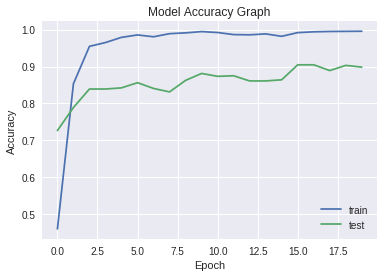

In [25]:
plt.plot(all_his_inc['acc'])
plt.plot(all_his_inc['val_acc'])
plt.title('Model Accuracy Graph')
plt.legend(['train', 'test'], loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

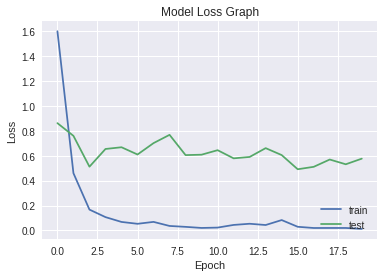

In [26]:
plt.plot(all_his_inc['loss'])
plt.plot(all_his_inc['val_loss'])
plt.title('Model Loss Graph')
plt.legend(['train', 'test'], loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

**Xception**

In [0]:
# plt.plot(all_his_x['acc'])
# plt.plot(all_his_x['val_acc'])
# plt.title('Model Accuracy Graph')
# plt.legend(['train', 'test'], loc='lower right')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

In [0]:
# plt.plot(all_his_x['loss'])
# plt.plot(all_his_x['val_loss'])
# plt.title('Model Loss Graph')
# plt.legend(['train', 'test'], loc='lower right')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

**comparison between nets (test)**

In [0]:
# plt.plot(all_his_inc['val_acc'])
# plt.plot(all_his_x['val_acc'])
# plt.title('Model Accuracy Graph')
# plt.legend(['InceptionV3', 'Xception'], loc='lower right')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

# Ensemble

---



In [0]:
# def ensemble(models_list, model_input):
#     outputs = [model(model_input) for model in models_list]
#     y = Average()(outputs)
#     model = Model(model_input, y, name='ensemble')
#     return model

In [0]:
# models = [xmodel, resmodel]

# model_input = Input(shape=(target_height,target_width,3))
# ensembled_model = ensemble(models, model_input)

Predicts a single (quite big) batch, and shows the confusion matrix.

In [32]:
pred_gen = data_generator(x_test,y_test, batch_size = 256, shuffle=True)
x_pred,y_pred = next(pred_gen)
p_y_one_hot = one_hot_to_class(y_pred)

prediction = inc_net.predict(x_pred, batch_size = 256 , verbose = 1)
prob_class = prediction.argmax(axis=-1)

256/256 [==============================] - 5s 19ms/step


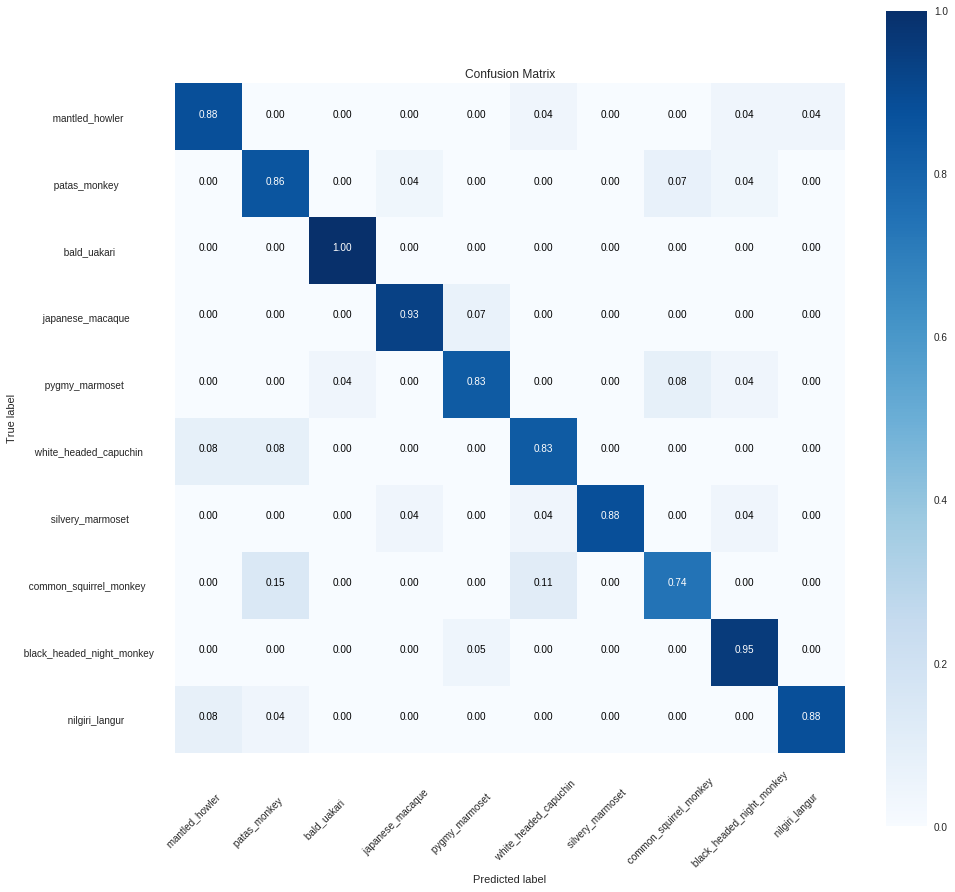

In [33]:
c_matrix = confusion_matrix(p_y_one_hot, prob_class)
c_matrix = c_matrix.astype('float') / c_matrix.sum(axis=1)[:, np.newaxis]

tick_marks = np.arange(monk_classes)

plt.figure(figsize = (15,15))
plt.xticks(tick_marks, labels , rotation=45)
plt.yticks(tick_marks, labels , rotation=0)
fmt = '.2f'
thresh = c_matrix.max() / 2.
for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
        plt.text(j, i, format(c_matrix[i, j], fmt), horizontalalignment="center", color="white" if c_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.imshow(c_matrix,cmap = plt.cm.Blues)
plt.colorbar()
plt.grid(None)


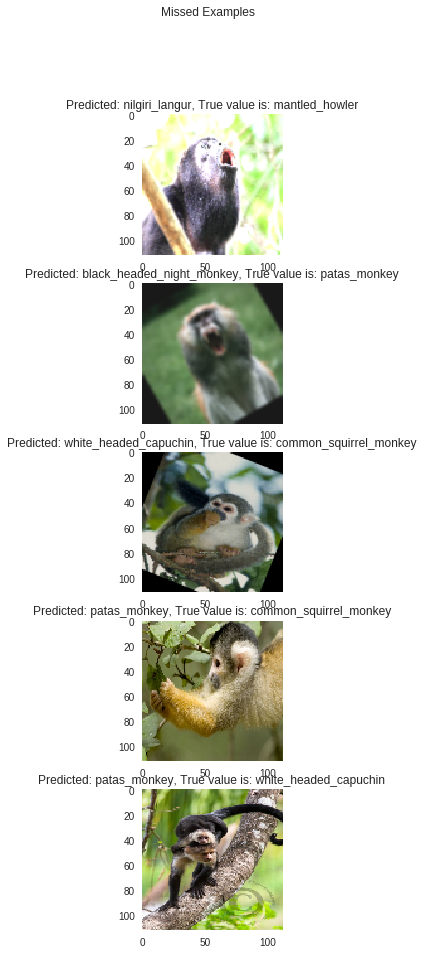

In [34]:
#Show 5 random missed predictions
num_of_shows = 5

missed_group = []
for val in range(len(prob_class)):
    if (prob_class[val] != p_y_one_hot[val]):
        missed_group.append(val)
    
plt.figure(figsize = (5,15))
for img in range(num_of_shows):
    index = np.random.randint(0,len(missed_group))
    plt.subplot(num_of_shows,1,img+1)
    image = x_pred[missed_group[index]]
    plt.imshow(image)
    title = "Predicted: " +str(m_dict[prob_class[missed_group[index]]]) +", True value is: " +str(m_dict[p_y_one_hot[missed_group[index]]])
    plt.title(title)
    plt.grid(None)
plt.suptitle("Missed Examples")
plt.show()

<Figure size 432x288 with 0 Axes>

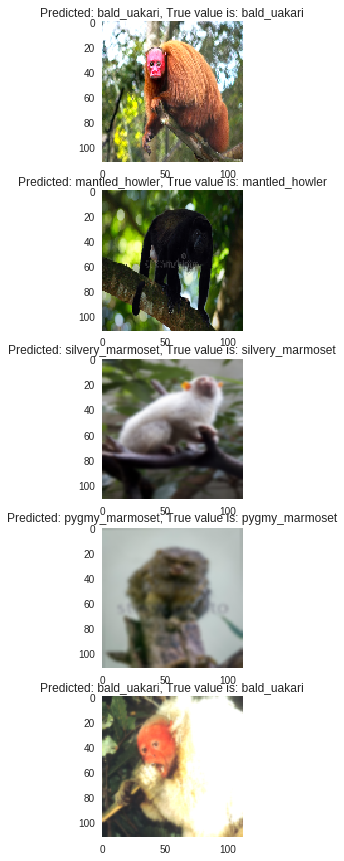

In [35]:
#Show 5 random good prediction
num_of_shows = 5
plt.suptitle("Prediction Examples")
pred_group = []
for val in range(len(prediction)):
    if (prob_class[val] == p_y_one_hot[val]):
        pred_group.append(val)
    
plt.figure(figsize = (5,15))
for img in range(num_of_shows):
    index = np.random.randint(0,len(pred_group))
    plt.subplot(num_of_shows,1,img+1)
    image = x_pred[pred_group[index]]
    plt.imshow(image)
    title = "Predicted: " +str(m_dict[prob_class[pred_group[index]]]) +", True value is: " +str(m_dict[p_y_one_hot[pred_group[index]]])
    plt.title(title)
    plt.grid(None)
plt.show()